In [89]:
import os
import shutil
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
from scipy.stats import norm
import seaborn as sns

In [4]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def train(trainloader, model, criterion, optimizer, epoch, use_cuda):
    # switch to train mode
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda(async=True)
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data[0], inputs.size(0))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return (losses.avg, top1.avg)


In [10]:
def test(testloader, model, criterion, epoch, use_cuda):
    global best_acc

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()

    for batch_idx, (inputs, targets) in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data[0], inputs.size(0))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return (losses.avg, top1.avg)

In [11]:
def main():
    global best_acc
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    epochs = 300
    use_cuda = False
    best_acc = 0
    old_loss = 1000000
    learning_rate = 0.01
    momentum = 0.9
    weight_decay = 5e-4
    # Data
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    dataloader = datasets.CIFAR10
    num_classes = 10
    train_batch = 128
    test_batch = 100
    workers = 4
    trainset = dataloader(root='./data', train=True, download=True, transform=transform_train)
    trainloader = data.DataLoader(trainset, batch_size=train_batch, shuffle=True, num_workers=workers)

    testset = dataloader(root='./data', train=False, download=False, transform=transform_test)
    testloader = data.DataLoader(testset, batch_size=test_batch, shuffle=False, num_workers=workers)
    
    model = AlexNet(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay= weight_decay)
    
    if use_cuda == True:
        model = model.cuda()
        criterion = criterion.cuda()
    # Train and val
    for epoch in range(start_epoch, epochs):
        
        train_loss, train_acc = train(trainloader, model, criterion, optimizer, epoch, use_cuda)
        test_loss, test_acc = test(testloader, model, criterion, epoch, use_cuda)
        print('Epoch: [%d | %d] LR: %f; Train Loss %f; Test Loss %f; Train acc %f; Test acc %f' 
              % (epoch + 1, epochs, optimizer.param_groups[0]['lr'],train_loss, test_loss, train_acc, test_acc))
        # save model
        is_best = test_acc > best_acc
        best_acc = max(test_acc, best_acc)
        if is_best:
            torch.save(model.state_dict(), 'model_'+str(epoch+1))
        if train_loss >= old_loss:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 1.0/2
        old_loss = train_loss

    print('Best acc:')
    print(best_acc)

In [ ]:
if __name__ == '__main__':
    main()

Files already downloaded and verified
Epoch: [1 | 300] LR: 0.010000; Train Loss 2.092275; Test Loss 1.780316; Train acc 20.146000; Test acc 32.450000
Epoch: [2 | 300] LR: 0.010000; Train Loss 1.671740; Test Loss 1.496918; Train acc 37.592000; Test acc 44.980000
Epoch: [3 | 300] LR: 0.010000; Train Loss 1.461508; Test Loss 1.402426; Train acc 46.256000; Test acc 49.650000
Epoch: [4 | 300] LR: 0.010000; Train Loss 1.340008; Test Loss 1.350916; Train acc 51.478000; Test acc 51.110000
Epoch: [5 | 300] LR: 0.010000; Train Loss 1.253610; Test Loss 1.200557; Train acc 54.842000; Test acc 57.130000
Epoch: [6 | 300] LR: 0.010000; Train Loss 1.197275; Test Loss 1.108325; Train acc 57.228000; Test acc 61.180000
Epoch: [7 | 300] LR: 0.010000; Train Loss 1.129193; Test Loss 1.054745; Train acc 59.708000; Test acc 62.910000
Epoch: [8 | 300] LR: 0.010000; Train Loss 1.078159; Test Loss 1.074289; Train acc 61.642000; Test acc 62.540000
Epoch: [9 | 300] LR: 0.010000; Train Loss 1.033161; Test Loss 1.03

In [3]:
model = AlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

NameError: name 'AlexNet' is not defined

In [37]:
optimizer.param_groups[0]['lr']

0.01

In [3]:
model_state = torch.load('model_35')

In [14]:
num_classes = 10
model = AlexNet(10)
model_state = torch.load('model_35')
model.load_state_dict(model_state)

In [15]:
model.eval()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Linear (256 -> 10)
)

In [105]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
])
dataloader = datasets.CIFAR100
num_classes = 10
train_batch = 128
test_batch = 100
workers = 4
trainset = dataloader(root='./data', train=True, download=True, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=train_batch, shuffle=True, num_workers=workers)

In [6]:
for batch_idx, (inputs, targets) in enumerate(trainloader):
    a = inputs
    print(type(a))
    break

<class 'torch.FloatTensor'>


In [7]:
num_classes = 10
model = AlexNet(10)
model_state = torch.load('model_107', map_location=lambda storage, loc: storage)
model.load_state_dict(model_state)

In [103]:
def margin(trainloader, model):
#     model = AlexNet(num_classes)
#     model_state = torch.load('model_'+str(iterations[i]), map_location=lambda storage, loc: storage)
#     model.load_state_dict(model_state)
    margin = []
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inp = inputs
        tar = targets
        b = model(Variable(inputs))
        c = b.topk(2)[0][:,1].data.numpy()
        bnp = b.data.numpy()
        for j in range(b.shape[0]):
            margin.append(bnp[j,tar[j]]-c[j])
    margin = np.array(margin)

In [104]:
# iterations = [20,38,59,86,107]
iterations = [300]
colors = ['red', 'blue', 'yellow', 'green', 'purple']
num_classes = 10
bins_all = []
mu_all = []
sigma_all = []
for i in range(len(iterations)):
    model = AlexNet(num_classes)
    model_state = torch.load('model_'+str(iterations[i]), map_location=lambda storage, loc: storage)
    model.load_state_dict(model_state)
    margin = []
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inp = inputs
        tar = targets
        b = model(Variable(inputs))
        c = b.topk(2)[0][:,1].data.numpy()
        bnp = b.data.numpy()
        for j in range(b.shape[0]):
            margin.append(bnp[j,tar[j]]-c[j])
    margin = np.array(margin)
    sns.distplot(margin, hist=False, color=colors[i], kde_kws={"shade": True}, label = str(iterations[i])+' Epochs')
#     n,bins,patches = plt.hist(margin, 60, normed=1, alpha=0.75)
#     (mu, sigma) = norm.fit(margin)
#     plt.clf()
#     bins_all.append(bins)
#     mu_all.append(mu)
#     sigma_all.append(sigma)
# for i in range(5):
#     y = mlab.normpdf( bins_all[i], mu_all[i], sigma_all[i])
#     plt.plot(bins_all[i], y, colors[i], linewidth=2, label = str(iterations[i])+' epochs')
# plt.grid(True)
plt.legend()
plt.show()

Process Process-95:
Process Process-96:
Process Process-93:
Process Process-94:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  Fi

KeyboardInterrupt: 

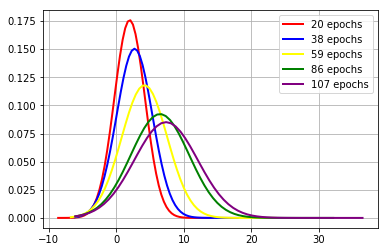

In [83]:
for i in range(5):
    y = mlab.normpdf( bins_all[i], mu_all[i], sigma_all[i])
    plt.plot(bins_all[i], y, colors[i], linewidth=2, label = str(iterations[i])+' epochs')
plt.grid(True)
plt.legend()
plt.show()

In [85]:
### Calculate spectral complexity 
i = 4
model = AlexNet(num_classes)
model_state = torch.load('model_'+str(iterations[i]), map_location=lambda storage, loc: storage)
model.load_state_dict(model_state)

In [45]:
for batch_idx, (inputs, targets) in enumerate(trainloader):
    inp = inputs
    tar = targets
    b = model(Variable(inputs))
    c = b.topk(2)[0][:,1].data.numpy()
    bnp = b.data.numpy()

numpy.ndarray

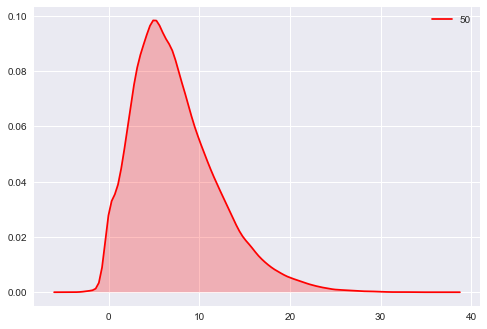

In [99]:

sns.distplot(margin, hist=False, color= 'r', kde_kws={"shade": True}, label = '50')
plt.legend()
plt.show()

In [101]:
type(model)

__main__.AlexNet

In [102]:
model1 = model.cuda()

AssertionError: Torch not compiled with CUDA enabled